In [1]:
import numpy as np
import matplotlib.pyplot as plt
from icecube import astro, dataio,paraboloid
import histlite as hl
import csky as cy
from csky import hyp
import pandas as pd
from importlib import reload
import tables
reload(cy.pdf)
%matplotlib inline

In [2]:
cy.plotting.mrichman_mpl()
timer = cy.timing.Timer()
time = timer.time

GC_ra , GC_dec = astro.gal_to_equa(0., 0.)
sindec_uplim = np.sin(GC_dec + np.radians(10))
sindec_lolim = np.sin(GC_dec - np.radians(10))
print(sindec_lolim)
print(sindec_uplim)

-0.6284542535027126
-0.3245146369013894


/home/xk35/csky/csky/plotting.py:92: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  r'\SetSymbolFont{operators}   {sans}{OT1}{cmss} {m}{n}'


In [3]:
MC = tables.open_file('/data/user/xk35/BDT_corrected/BDT_I_output/MC_v0/MC_cat_4000.hdf5')
#mask_MC = MC.root.SplineMPETruncatedEnergy_SPICEMie_AllBINS_MuEres.cols.exists[:]==1
Data = tables.open_file('/data/user/xk35/BDT_corrected/BDT_I_output/Data_v0/Data_cat_24days.hdf5')
#mask_Data = Data.root.SplineMPETruncatedEnergy_SPICEMie_AllBINS_MuEres.cols.exists[:]==1

In [6]:
dtype = [('run', int), ('event', int), ('subevent', int),
              ('ra', float), ('dec', float),('true_ra', float), ('true_dec', float),
                ('azi', float), ('zen', float), ('time', float),
               ('logE', float), ('angErr', float), ('oneweight', float), ('true_energy', float)]


mc = np.zeros(len(MC.root.I3EventHeader.cols.Run[:]), dtype=dtype)


mc['run'] = MC.root.I3EventHeader.cols.Run[:]
mc['event'] = MC.root.I3EventHeader.cols.Event[:]
mc['subevent'] = MC.root.I3EventHeader.cols.SubEvent[:]

mc['time'] = MC.root.I3EventHeader.cols.time_start_mjd[:]

MC_trueAzi = MC.root.I3MCWeightDict.cols.PrimaryNeutrinoAzimuth[:]
MC_trueZen = MC.root.I3MCWeightDict.cols.PrimaryNeutrinoZenith[:]
mc['true_ra'], mc['true_dec'] = astro.dir_to_equa(MC_trueZen, MC_trueAzi, mc['time'])
#mc['true_ra'] = MC_trueAzi
#mc['true_dec'] = MC_trueZen-np.pi/2


mc['azi'] = MC.root.SplineMPE.cols.azimuth[:]
mc['zen'] = MC.root.SplineMPE.cols.zenith[:]
mc['ra'], mc['dec'] = astro.dir_to_equa(mc['zen'], mc['azi'], mc['time'])
#mc['ra'] = mc['azi']
#mc['dec'] = mc['zen']-np.pi/2

#logE -> log10E
mc['logE'] = np.log10(MC.root.SplineMPEMuEXDifferential.cols.energy[:])

MC_err1 = MC.root.MPEFitParaboloidFitParams.cols.err1[:]
MC_err2 = MC.root.MPEFitParaboloidFitParams.cols.err2[:]
mc['angErr'] = np.sqrt((MC_err1**2+MC_err2**2)/2)
mc['oneweight'] = MC.root.I3MCWeightDict.cols.OneWeight[:]
mc['true_energy'] = MC.root.I3MCWeightDict.cols.PrimaryNeutrinoEnergy[:]




data = np.zeros(len(Data.root.I3EventHeader.cols.Run[:]), dtype=dtype)
data['run'] =Data.root.I3EventHeader.cols.Run[:]
data['event'] = Data.root.I3EventHeader.cols.Event[:]
data['subevent'] = Data.root.I3EventHeader.cols.SubEvent[:]
data['azi'] = Data.root.SplineMPE.cols.azimuth[:]
data['zen'] = Data.root.SplineMPE.cols.zenith[:]
data['time'] = Data.root.I3EventHeader.cols.time_start_mjd[:]
data['logE'] = np.log10(Data.root.SplineMPEMuEXDifferential.cols.energy[:])
Data_err1 = Data.root.MPEFitParaboloidFitParams.cols.err1[:]
Data_err2 = Data.root.MPEFitParaboloidFitParams.cols.err2[:]
data['angErr'] = np.sqrt((Data_err1**2+Data_err2**2)/2)

#data['ra'], data['dec'] = astro.dir_to_equa(data['zen'], data['azi'], data['time'])
data['ra'] = data['azi']
data['dec'] = data['zen']-np.pi/2

#data = data[mask_Data]
#mc = mc[mask_MC]

In [7]:
nfiles_sim = 4000
processed_events = MC.root.I3MCWeightDict.cols.NEvents[:][0]
mc['oneweight'] = mc['oneweight']/(nfiles_sim*processed_events)

In [8]:
LT_days = 0
for run in np.unique(data['run']):
    mask = (data['run'] == run)
    min_time = np.min(data[mask]['time'])
    max_time = np.max(data[mask]['time'])
    run_time = max_time - min_time
    #print(run_time)
    LT_days += run_time
LT = LT_days*86400
print(LT_days)

23.545279694066267


In [9]:
data_spec = cy.selections.CustomDataSpecs.CustomDataSpec(data, mc, LT, np.linspace(sindec_lolim, sindec_uplim, 2),
                                                        np.linspace(2, 10, 5))
#data_spec = cy.selections.PSDataSpecs.ps_10yr
repo = cy.selections.Repository()
with time('ana setup (from cache-to-disk)'):
    ana = cy.get_analysis(cy.selections.repo,data_spec)

Setting up Analysis for:
custom
Setting up custom...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.

0:00:00.554977 elapsed.


In [10]:
cy.CONF['ana'] = ana
cy.CONF['mp_cpus'] = 3

# Point Source Analysis

In [11]:
source_ra, source_dec = astro.gal_to_equa(0.,0.)
gamma = 2.7
src = cy.sources(source_ra, source_dec)
conf = {
    'flux':cy.hyp.PowerLawFlux(gamma), 'mp_cpus':3 #'fitter_args':dict(gamma=gamma)
}

tr = cy.get_trial_runner(src=src, conf = conf,ana = ana)

# Trial

In [12]:
trial = tr.get_one_trial(n_sig=1000, poisson=False, seed=1)
tuple(trial)

([[Events(53194 items | columns: dec, idx, inj, log10energy, ra, sigma, sindec),
   Events(1000 items | columns: dec, idx, inj, log10energy, ra, sigma, sindec)]],
 [135015])

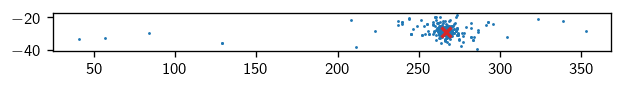

In [13]:
c = trial[-2][-1]
s = c[1]
fig, ax = plt.subplots()
plt.scatter(np.degrees(s.ra),np.degrees(s.dec), s = 0.5)
plt.scatter(np.degrees(source_ra), np.degrees(source_dec),marker = 'x')
ax.set_aspect('equal')

266.404996225917 -28.936172013030074


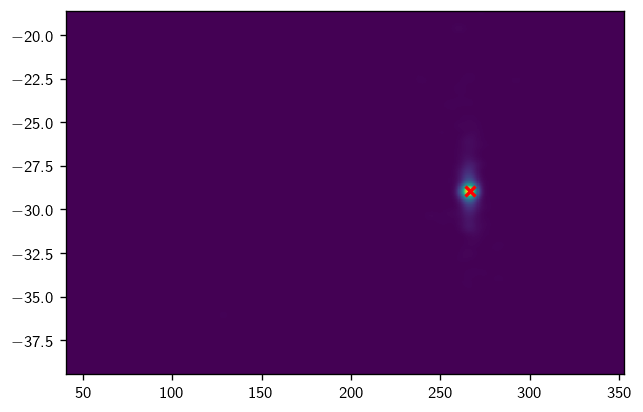

In [14]:
all_sig_ev = cy.utils.Arrays.concatenate([evs[1] for evs in trial.evss])
hl.plot2d(hl.kde((all_sig_ev.ra_deg, all_sig_ev.dec_deg))) # range=((0, 360), (-100, 100))))
#plt.gca().set_aspect('equal')
print(np.degrees(GC_ra), np.degrees(GC_dec))
plt.scatter(src.ra_deg, src.dec_deg, c='r', marker='x')

# Background Estimation

In [15]:
with time('ps bg trials'):
    n_trials = 1000
    bg = cy.dists.Chi2TSD(tr.get_many_fits(n_trials))
    #bg = cy.dists.Chi2TSD(tr.get_many_fits(n_trials,15))

Performing 1000 background trials using 3 cores:
       1000/1000 trials complete.   

0:00:15.935853 elapsed.


In [16]:
print(bg)

Chi2TSD(1000 trials, eta=0.437, ndof=1.080, median=0.000 (from fit 0.000))


In [17]:
print(bg.description)

Chi2TSD from 1000 trials:
           eta = 0.437
          ndof = 1.080
           loc = 0.000
         scale = 0.840
Thresholds from trials:
        median = 0.000
       1 sigma = 0.78
       2 sigma = 3.33
       3 sigma = 7.57
       4 sigma = 13.48
       5 sigma = 21.06
Thresholds from fit:
        median = 0.000
       1 sigma = 0.78
       2 sigma = 3.33
       3 sigma = 7.57
       4 sigma = 13.48
       5 sigma = 21.06


/home/xk35/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


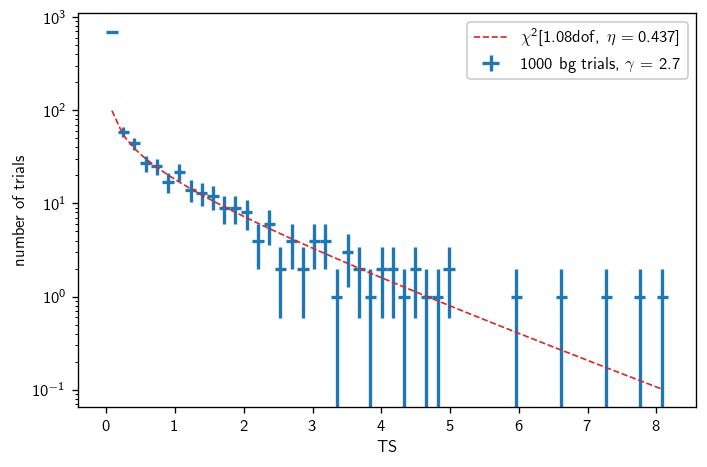

In [18]:
fig, ax = plt.subplots()

# csky uses histlite all over the place for PDF management
# the background distribution fit integrates with histlite as well
h = bg.get_hist(bins=50)
hl.plot1d(ax, h, crosses=True,
          label='{} bg trials, $\gamma$ = {}'.format(bg.n_total, gamma))

# compare with the chi2 fit:
x = h.centers[0]
norm = h.integrate().values
ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--',
            label=r'$\chi^2[{:.2f}\text{{dof}},\ \eta={:.3f}]$'.format(bg.ndof, bg.eta))

# always label your plots, folks
ax.set_xlabel(r'TS')
ax.set_ylabel(r'number of trials')
ax.legend()
#plt.title('After Cut')
plt.tight_layout()
#plt.savefig('BDTPlots/after_cut_TS_list_gamma_{}.png'.format(gamma))

# sensitivity snd discovery potential

In [19]:
with time('ps sensitivity'):
    sens = tr.find_n_sig(
        # ts, threshold
        bg.median(),
        # beta, fraction of trials which should exceed the threshold
        0.9,
        # n_inj step size for initial scan
        n_sig_step=5,
        # this many trials at a time
        batch_size=500,
        # tolerance, as estimated relative error
        tol=.05
    )

Start time: 2022-02-09 14:29:52.282131
Using 3 cores.
* Starting initial scan for 90% of 50 trials with TS >= 0.000...
  n_sig = 5.000 ... frac = 0.64000
  n_sig = 10.000 ... frac = 0.76000
  n_sig = 15.000 ... frac = 0.90000
* Generating batches of 500 trials...
n_trials | n_inj    0.00    6.00   12.00   18.00   24.00   30.00  |  n_sig(relative error)
500      |         43.6%   74.6%   90.2%   98.4%   99.4%  100.0%  |     11.889 (+/-  5.3%) [spline]
1000     |         43.0%   73.7%   90.1%   97.0%   99.4%   99.9%  |     11.939 (+/-  4.8%) [spline]
End time: 2022-02-09 14:31:38.078769
Elapsed time: 0:01:45.796638

0:01:45.797835 elapsed.


In [20]:
with time('ps discovery potential'):
    disc = tr.find_n_sig(bg.isf_nsigma(5), 0.5, n_sig_step=5, batch_size=500, tol=.05)


Start time: 2022-02-09 14:31:38.088913
Using 3 cores.
* Starting initial scan for 50% of 50 trials with TS >= 21.058...
  n_sig = 5.000 ... frac = 0.00000
  n_sig = 10.000 ... frac = 0.00000
  n_sig = 15.000 ... frac = 0.00000
  n_sig = 20.000 ... frac = 0.00000
  n_sig = 25.000 ... frac = 0.12000
  n_sig = 30.000 ... frac = 0.12000
  n_sig = 35.000 ... frac = 0.22000
  n_sig = 40.000 ... frac = 0.34000
  n_sig = 45.000 ... frac = 0.60000
* Generating batches of 500 trials...
n_trials | n_inj    0.00   18.00   36.00   54.00   72.00   90.00  |  n_sig(relative error)
500      |          0.0%    1.0%   32.2%   77.2%   96.4%  100.0%  |     42.935 (+/-  1.3%) [spline]
End time: 2022-02-09 14:32:42.950484
Elapsed time: 0:01:04.861571

0:01:04.864218 elapsed.


In [21]:
fmt2 = '{:.3e} TeV/cm2/s @ 100 TeV'
print(fmt2.format(tr.to_E2dNdE(sens['n_sig'], E0=100, unit=1e3)))
print(fmt2.format(tr.to_E2dNdE(disc['n_sig'], E0=100, unit=1e3)))

5.672e-10 TeV/cm2/s @ 100 TeV
2.040e-09 TeV/cm2/s @ 100 TeV


# Test for bias

In [22]:
n_sigs = np.r_[:101:10]
with time('ps fit bias trials'):
    trials = [tr.get_many_fits(100, n_sig=n_sig, logging=False, seed=n_sig) for n_sig in n_sigs]


0:00:24.816161 elapsed.


In [23]:
for (n_sig, t) in zip(n_sigs, trials):
    t['ntrue'] = np.repeat(n_sig, len(t))

In [24]:
allt = cy.utils.Arrays.concatenate(trials)

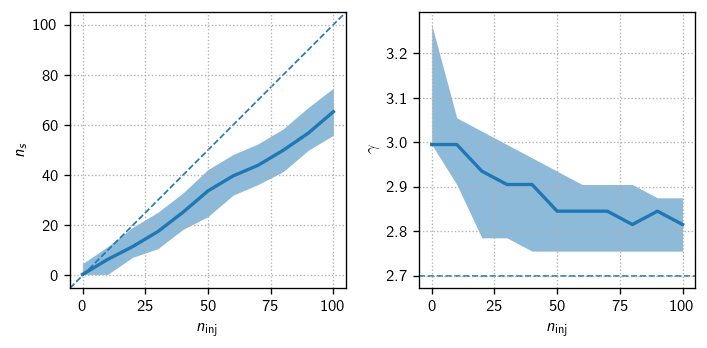

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(6,3))

dns = np.mean(np.diff(n_sigs))
ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)
expect_gamma = tr.sig_injs[0].flux[0].gamma

ax = axs[0]
h = hl.hist((allt.ntrue, allt.ns), bins=(ns_bins, 100))
hl.plot1d(ax, h.contain_project(1),errorbands=True, drawstyle='default')

lim = ns_bins[[0, -1]]
ax.set_xlim(ax.set_ylim(lim))
ax.plot(lim, lim, **expect_kw)
ax.set_aspect('equal')


ax = axs[1]
h = hl.hist((allt.ntrue, allt.gamma), bins=(ns_bins, 100))
hl.plot1d(ax, h.contain_project(1),errorbands=True, drawstyle='default')
ax.axhline(expect_gamma, **expect_kw)
ax.set_xlim(axs[0].get_xlim())

for ax in axs:
    ax.set_xlabel(r'$n_\text{inj}$')
    ax.grid()
axs[0].set_ylabel(r'$n_s$')
axs[1].set_ylabel(r'$\gamma$')

plt.tight_layout()
#plt.savefig('BDTPlots/after_cut_bias_GC_gamma_{}.png'.format(gamma))